In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
from scipy.special import expit
from scipy.special import logsumexp
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint
from scipy.signal import convolve
from scipy.interpolate import interp1d

import divebomb

import time
import pickle

import importlib

matplotlib.rcParams.update({'font.size': 24})
matplotlib.rcParams.update({'lines.markersize': 20})

np.random.seed(0)

In [2]:
import Preprocessor
import Parameters
import HHMM
import Visualisor

In [3]:
train_new = False

In [4]:
pars = Parameters.Parameters()

pars.features = [{'dive_duration':{'corr':False,'f':'gamma'}},
                 {'Ax':{'corr':True,'f':'normal'},
                  'Ay':{'corr':True,'f':'normal'},
                  'Az':{'corr':True,'f':'normal'},
                  'Ahat_low':{'thresh':5,'corr':False,'f':'gamma'}}]

prep = Preprocessor.Preprocessor(pars)

In [5]:
np.set_printoptions(suppress=True,precision=4)

In [6]:
s_dive = 0
e_dive = 266
pars.K[0] = 2
pars.K[1] = 3
pars.share_fine_states = True
HHMM_file = '../Params/HHMM_k_%s_%s_dives_%s_%s_same_fine_states_A' % (pars.K[0],pars.K[1],s_dive,e_dive)
print(HHMM_file)

../Params/HHMM_k_2_3_dives_0_266_same_fine_states_A


# Preprocess Data

In [7]:
df = prep.load_data(pars.cvc_file,
                    pars.csv_file,
                    pars.cvc_cols)

df = prep.prune_cols(df)

df = prep.prune_times(df,
                      pars.stime,
                      pars.etime,
                      pars.drop_times)

df = prep.fix_pressure(df)

df = prep.find_Vz(df)

df = prep.smooth_columns(df,
                         pars.smoother,
                         pars.smooth_cols)

df,dive_df = prep.find_dives(df)

data = prep.get_all_features(df,dive_df)

viz = Visualisor.Visualisor(pars,data,df)

In [8]:
df[(df['dive_num'] >= 160) & (df['dive_num'] <= 165)]

,Az,Ax,time,Ay,VeDBA,depth,sec_from_start,hr_from_start,time_series,elevation,Vz,dive_num
310060,-0.614645,-0.367409,2019-09-02 15:21:01.200,0.678140,0.986231,0.515266,9492.20,2.636722,1,-0.515266,-0.462582,160
310061,-0.526954,-0.151847,2019-09-02 15:21:01.220,0.991432,1.132994,0.521476,9492.22,2.636728,1,-0.521476,-0.452931,160
310062,-0.623487,-0.018522,2019-09-02 15:21:01.240,0.961245,1.145894,0.540134,9492.24,2.636733,1,-0.540134,-0.441963,160
310063,-0.656914,0.102430,2019-09-02 15:21:01.260,0.611334,0.903193,0.540120,9492.26,2.636739,1,-0.540120,-0.431809,160
310064,-0.736205,0.305207,2019-09-02 15:21:01.280,0.438732,0.909744,0.546330,9492.28,2.636744,1,-0.546330,-0.420810,160
...,...,...,...,...,...,...,...,...,...,...,...,...
327086,-0.701271,-0.514350,2019-09-02 15:26:41.720,0.711066,1.123366,0.398327,9832.72,2.731311,1,-0.398327,-0.821319,165
327087,-0.571256,-0.324020,2019-09-02 15:26:41.740,0.722482,0.976372,0.416998,9832.74,2.731317,1,-0.416998,-0.816200,165
327088,-0.378384,-0.500766,2019-09-02 15:26:41.760,0.830198,1.040755,0.416998,9832.76,2.731322,1,-0.416998,-0.810850,165
327089,-0.834707,0.049089,2019-09-02 15:26:41.780,0.764088,1.132685,0.448117,9832.78,2.731328,1,-0.448117,-0.804522,165


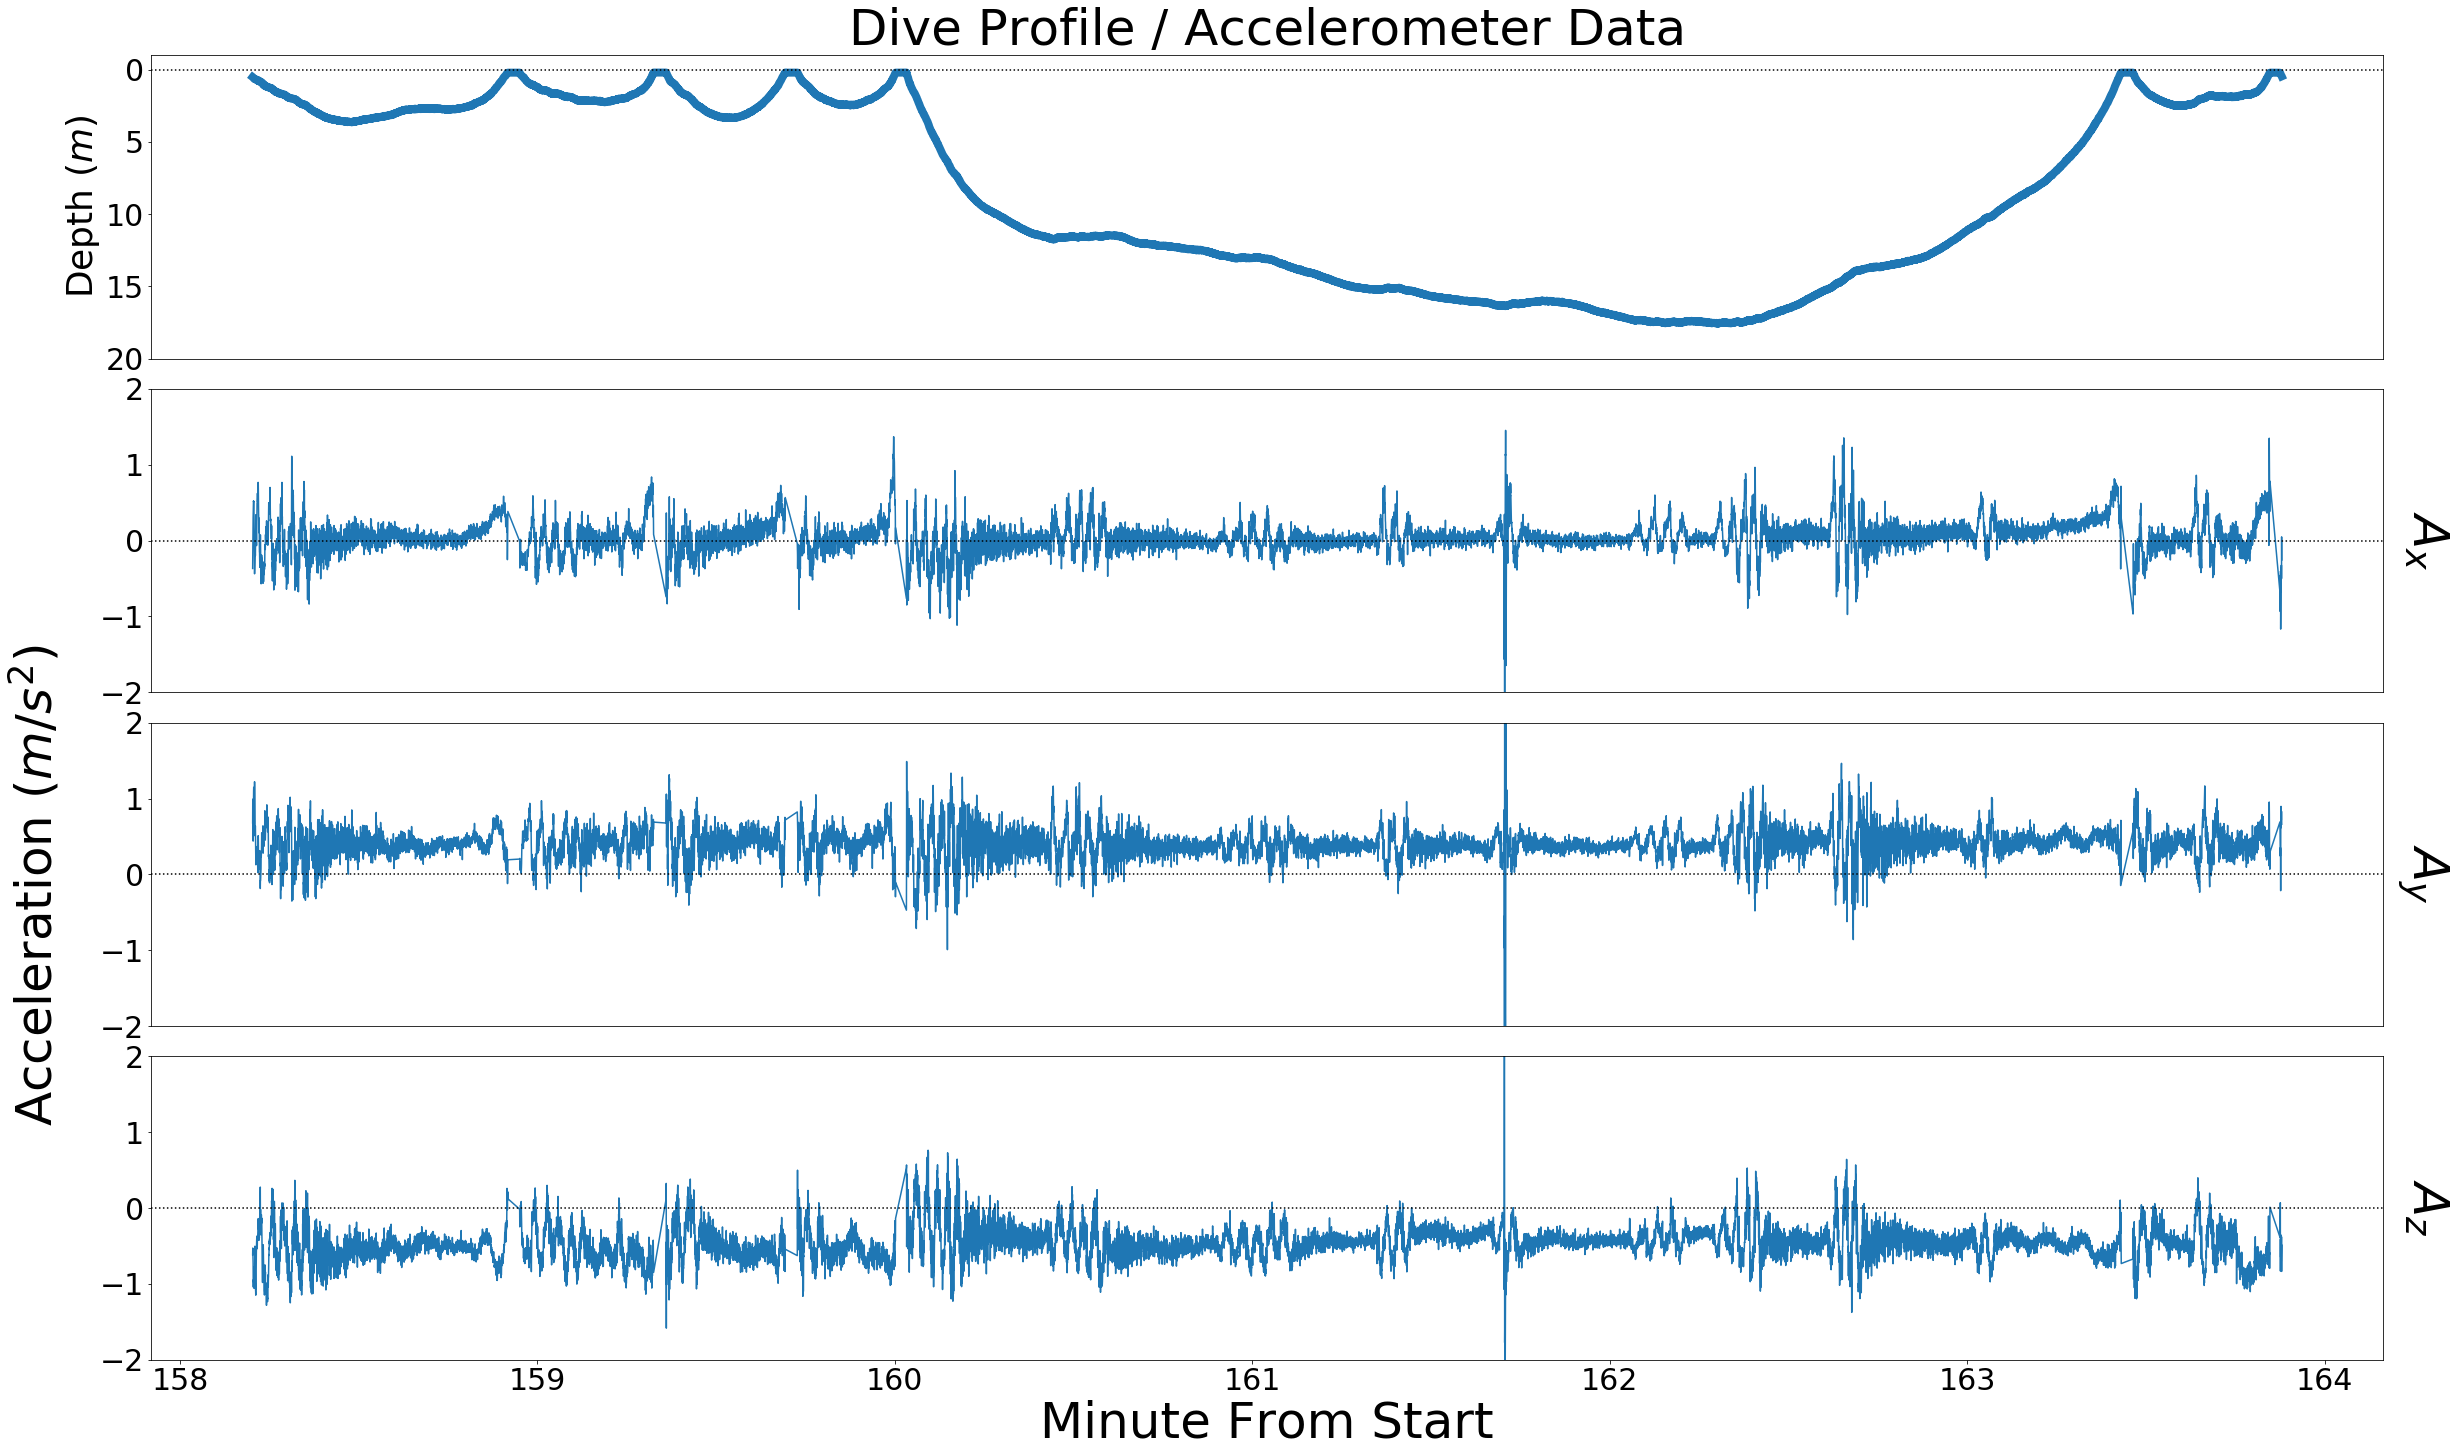

In [9]:
fig,ax = plt.subplots(4,1,figsize = (40,24))
ax[1].yaxis.set_label_position("right")
ax[2].yaxis.set_label_position("right")
ax[3].yaxis.set_label_position("right")

temp_df = df[(df['dive_num'] >= 160) & (df['dive_num'] <= 165)]

plt.subplot(4,1,1)
plt.ylabel('Depth $(m)$',fontsize=30)
plt.plot(temp_df['hr_from_start'],temp_df['depth'],linewidth=8)
plt.title('Dive Profile / Accelerometer Data',fontsize=50)
plt.ylim([20,-1])
plt.xticks([])
plt.axhline(0,color='k',linestyle=':')
plt.ylabel('Depth $(m)$',fontsize=36)
plt.yticks(fontsize=30)

plt.subplot(4,1,2)
ax = plt.gca()
ax.yaxis.set_label_coords(1.03,0.5)
ax.yaxis.set_label_position("right")
ax.set_ylabel('$A_x$',fontsize=50,rotation=270)
plt.plot(temp_df['hr_from_start']*60,temp_df['Ax'])
plt.xticks([])
plt.ylim([-2,2])
plt.axhline(0,color='k',linestyle=':')
plt.yticks(fontsize=30)

plt.subplot(4,1,3)
ax = plt.gca()
ax.yaxis.set_label_coords(1.03,0.5)
ax.yaxis.set_label_position("right")
ax.set_ylabel('$A_y$',fontsize=50,rotation=270)
plt.plot(temp_df['hr_from_start']*60,temp_df['Ay'])
plt.xticks([])
plt.ylim([-2,2])
plt.axhline(0,color='k',linestyle=':')
plt.yticks(fontsize=30)

plt.subplot(4,1,4)
ax = plt.gca()
ax.yaxis.set_label_coords(1.03,0.5)
ax.yaxis.set_label_position("right")
ax.set_ylabel('$A_z$',fontsize=50,rotation=270)
plt.plot(temp_df['hr_from_start']*60,temp_df['Az'])
plt.xlabel('Minute From Start',fontsize=50)
plt.ylim([-2,2])
plt.axhline(0,color='k',linestyle=':')
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)

fig.text(0.075, 0.4, 'Acceleration $(m/s^2)$', va='center', rotation='vertical',fontsize=50)
plt.subplots_adjust(wspace=0, hspace=0.1)

plt.savefig('../Plots/raw_data_5_dives.png')
plt.show()

del temp_df

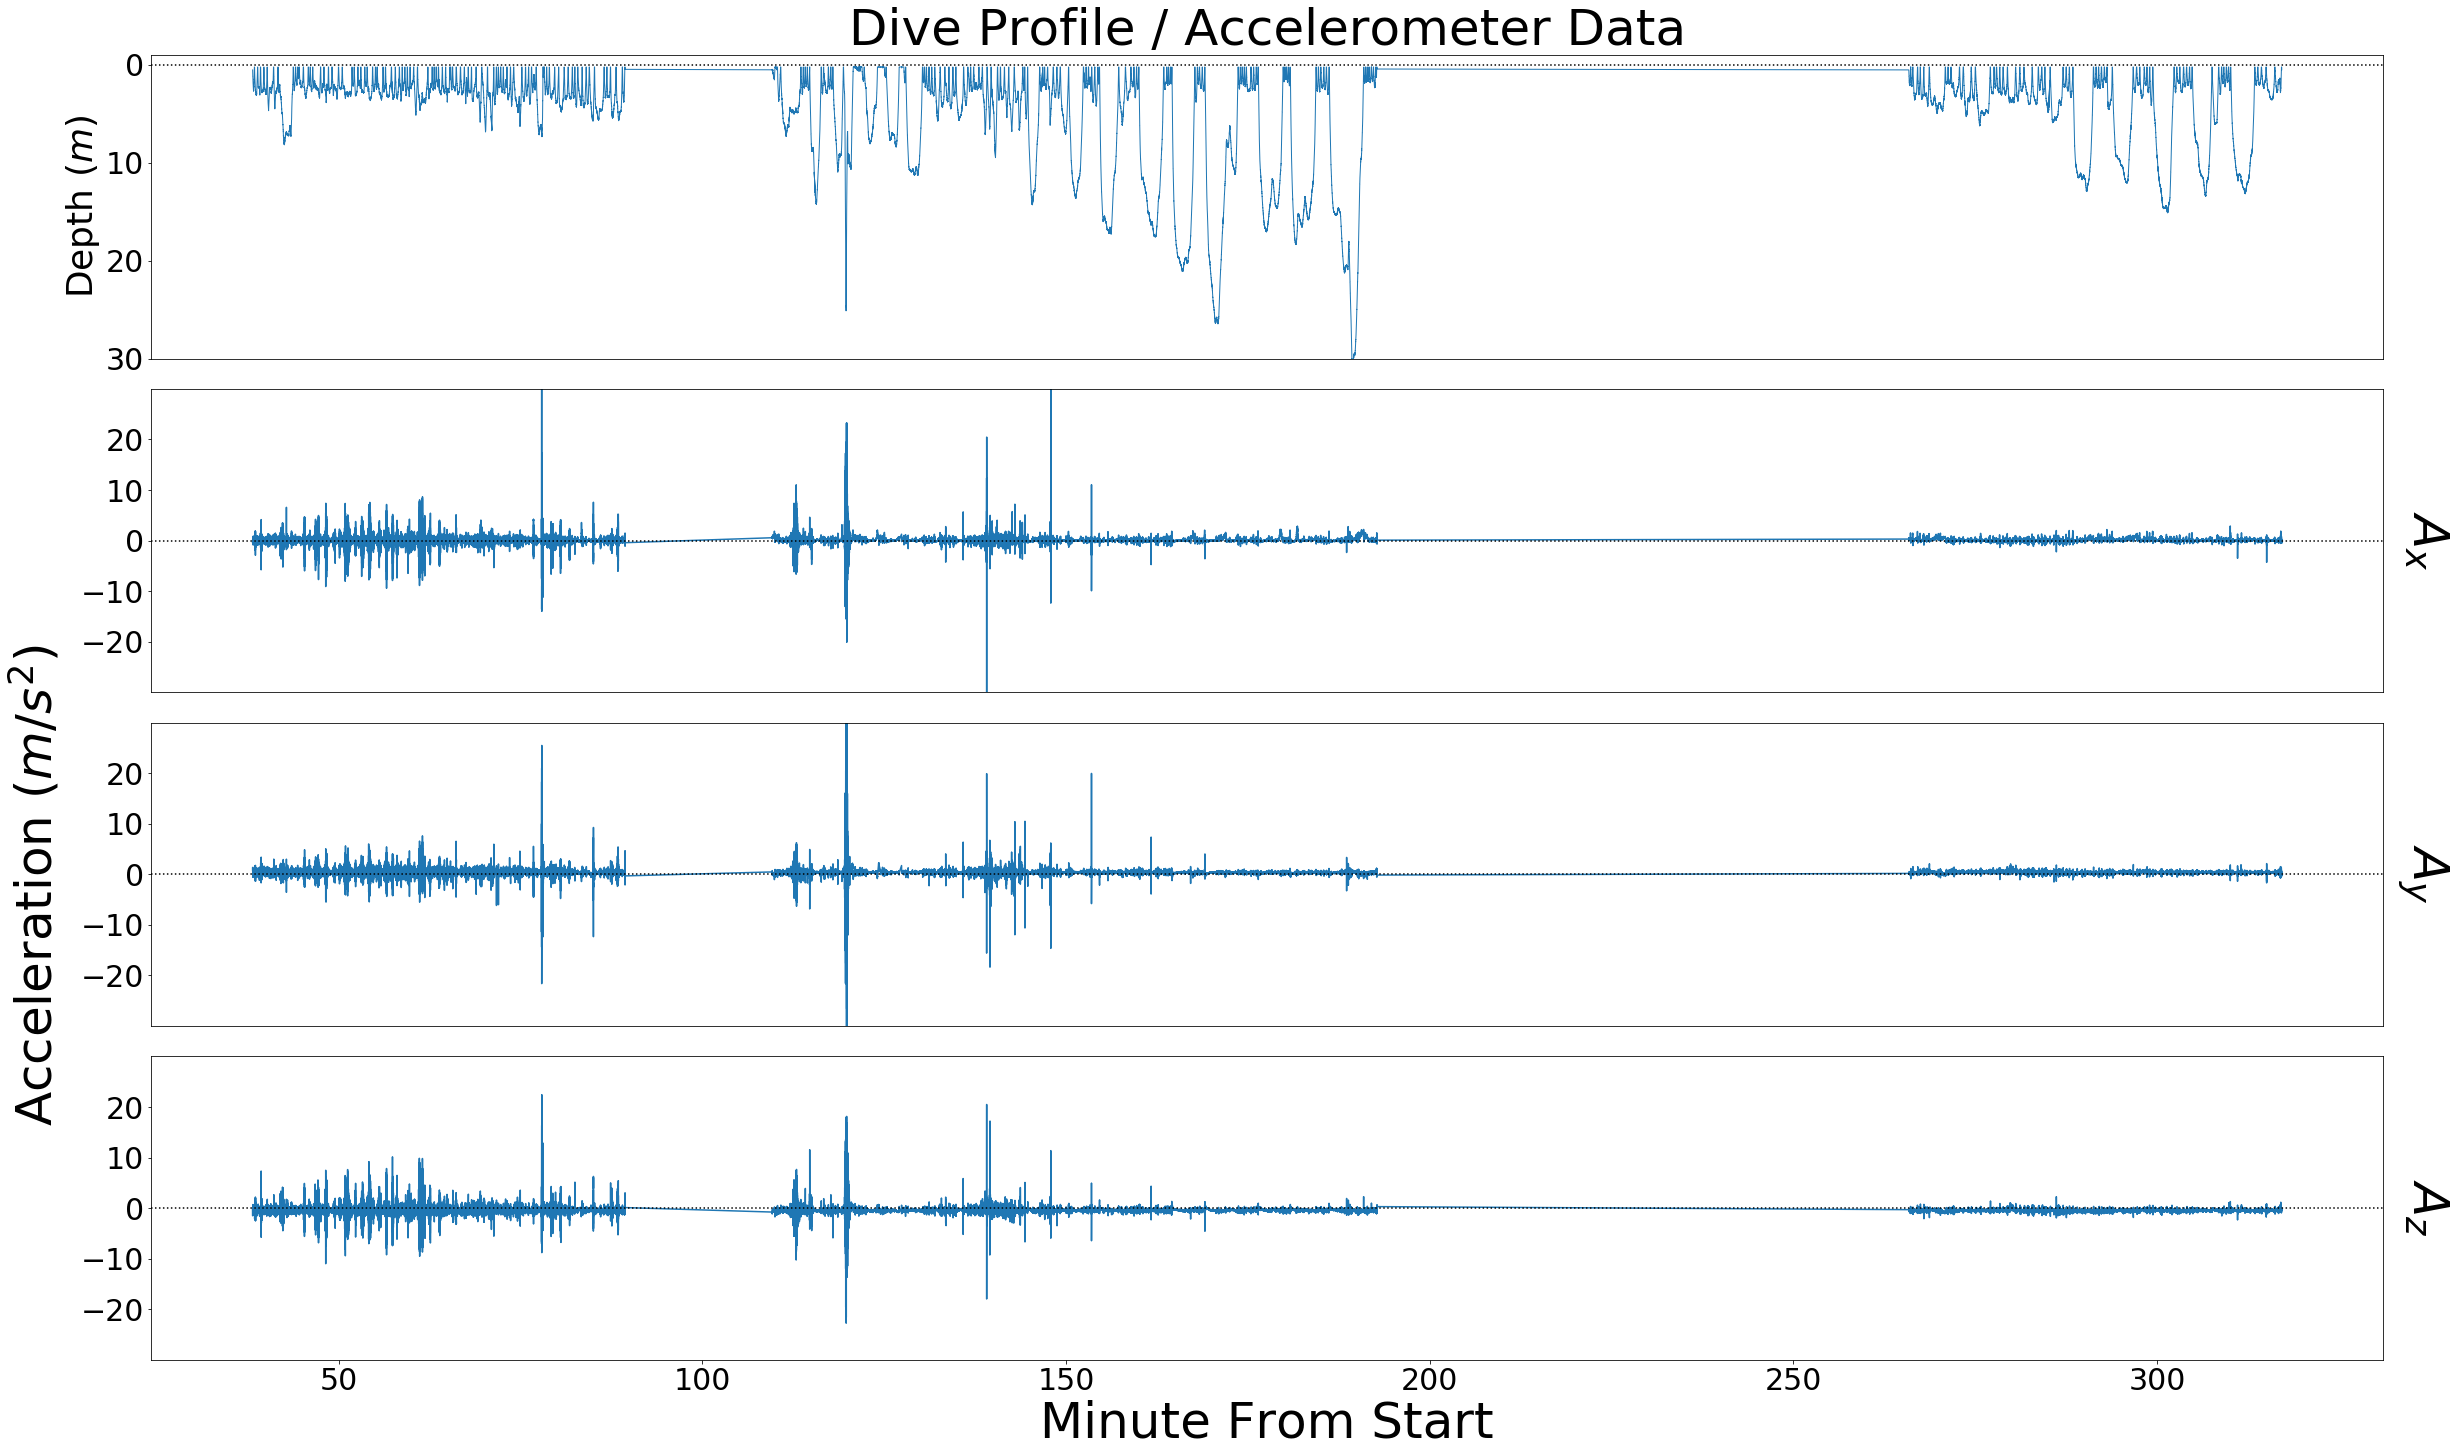

In [10]:
fig,ax = plt.subplots(4,1,figsize = (40,24),sharex=True)
ax[1].yaxis.set_label_position("right")
ax[2].yaxis.set_label_position("right")
ax[3].yaxis.set_label_position("right")

temp_df = df

plt.subplot(4,1,1)
plt.plot(temp_df['hr_from_start'],temp_df['depth'],linewidth=1)
plt.title('Dive Profile / Accelerometer Data',fontsize=50)
plt.ylim([30,-1])
plt.xticks([])
plt.axhline(0,color='k',linestyle=':')
plt.ylabel('Depth $(m)$',fontsize=36)
plt.yticks([0,10,20,30],fontsize=30)

plt.subplot(4,1,2)
ax = plt.gca()
ax.yaxis.set_label_coords(1.03,0.5)
ax.yaxis.set_label_position("right")
ax.set_ylabel('$A_x$',fontsize=50,rotation=270)
plt.plot(temp_df['hr_from_start']*60,temp_df['Ax'])
plt.xticks([])
plt.ylim([-30,30])
plt.axhline(0,color='k',linestyle=':')
plt.yticks([-20,-10,0,10,20],fontsize=30)

plt.subplot(4,1,3)
ax = plt.gca()
ax.yaxis.set_label_coords(1.03,0.5)
ax.yaxis.set_label_position("right")
ax.set_ylabel('$A_y$',fontsize=50,rotation=270)
plt.plot(temp_df['hr_from_start']*60,temp_df['Ay'])
plt.xticks([])
plt.ylim([-30,30])
plt.axhline(0,color='k',linestyle=':')
plt.yticks([-20,-10,0,10,20],fontsize=30)

plt.subplot(4,1,4)
ax = plt.gca()
ax.yaxis.set_label_coords(1.03,0.5)
ax.yaxis.set_label_position("right")
ax.set_ylabel('$A_z$',fontsize=50,rotation=270)
plt.plot(temp_df['hr_from_start']*60,temp_df['Az'])
plt.xlabel('Minute From Start',fontsize=50)
plt.ylim([-30,30])
plt.axhline(0,color='k',linestyle=':')
plt.yticks([-20,-10,0,10,20],fontsize=30)
plt.xticks(fontsize=30)

fig.text(0.075, 0.4, 'Acceleration $(m/s^2)$', va='center', rotation='vertical',fontsize=50)

del temp_df
plt.subplots_adjust(wspace=0, hspace=0.1)
plt.savefig('../Plots/raw_data.png')
plt.show()

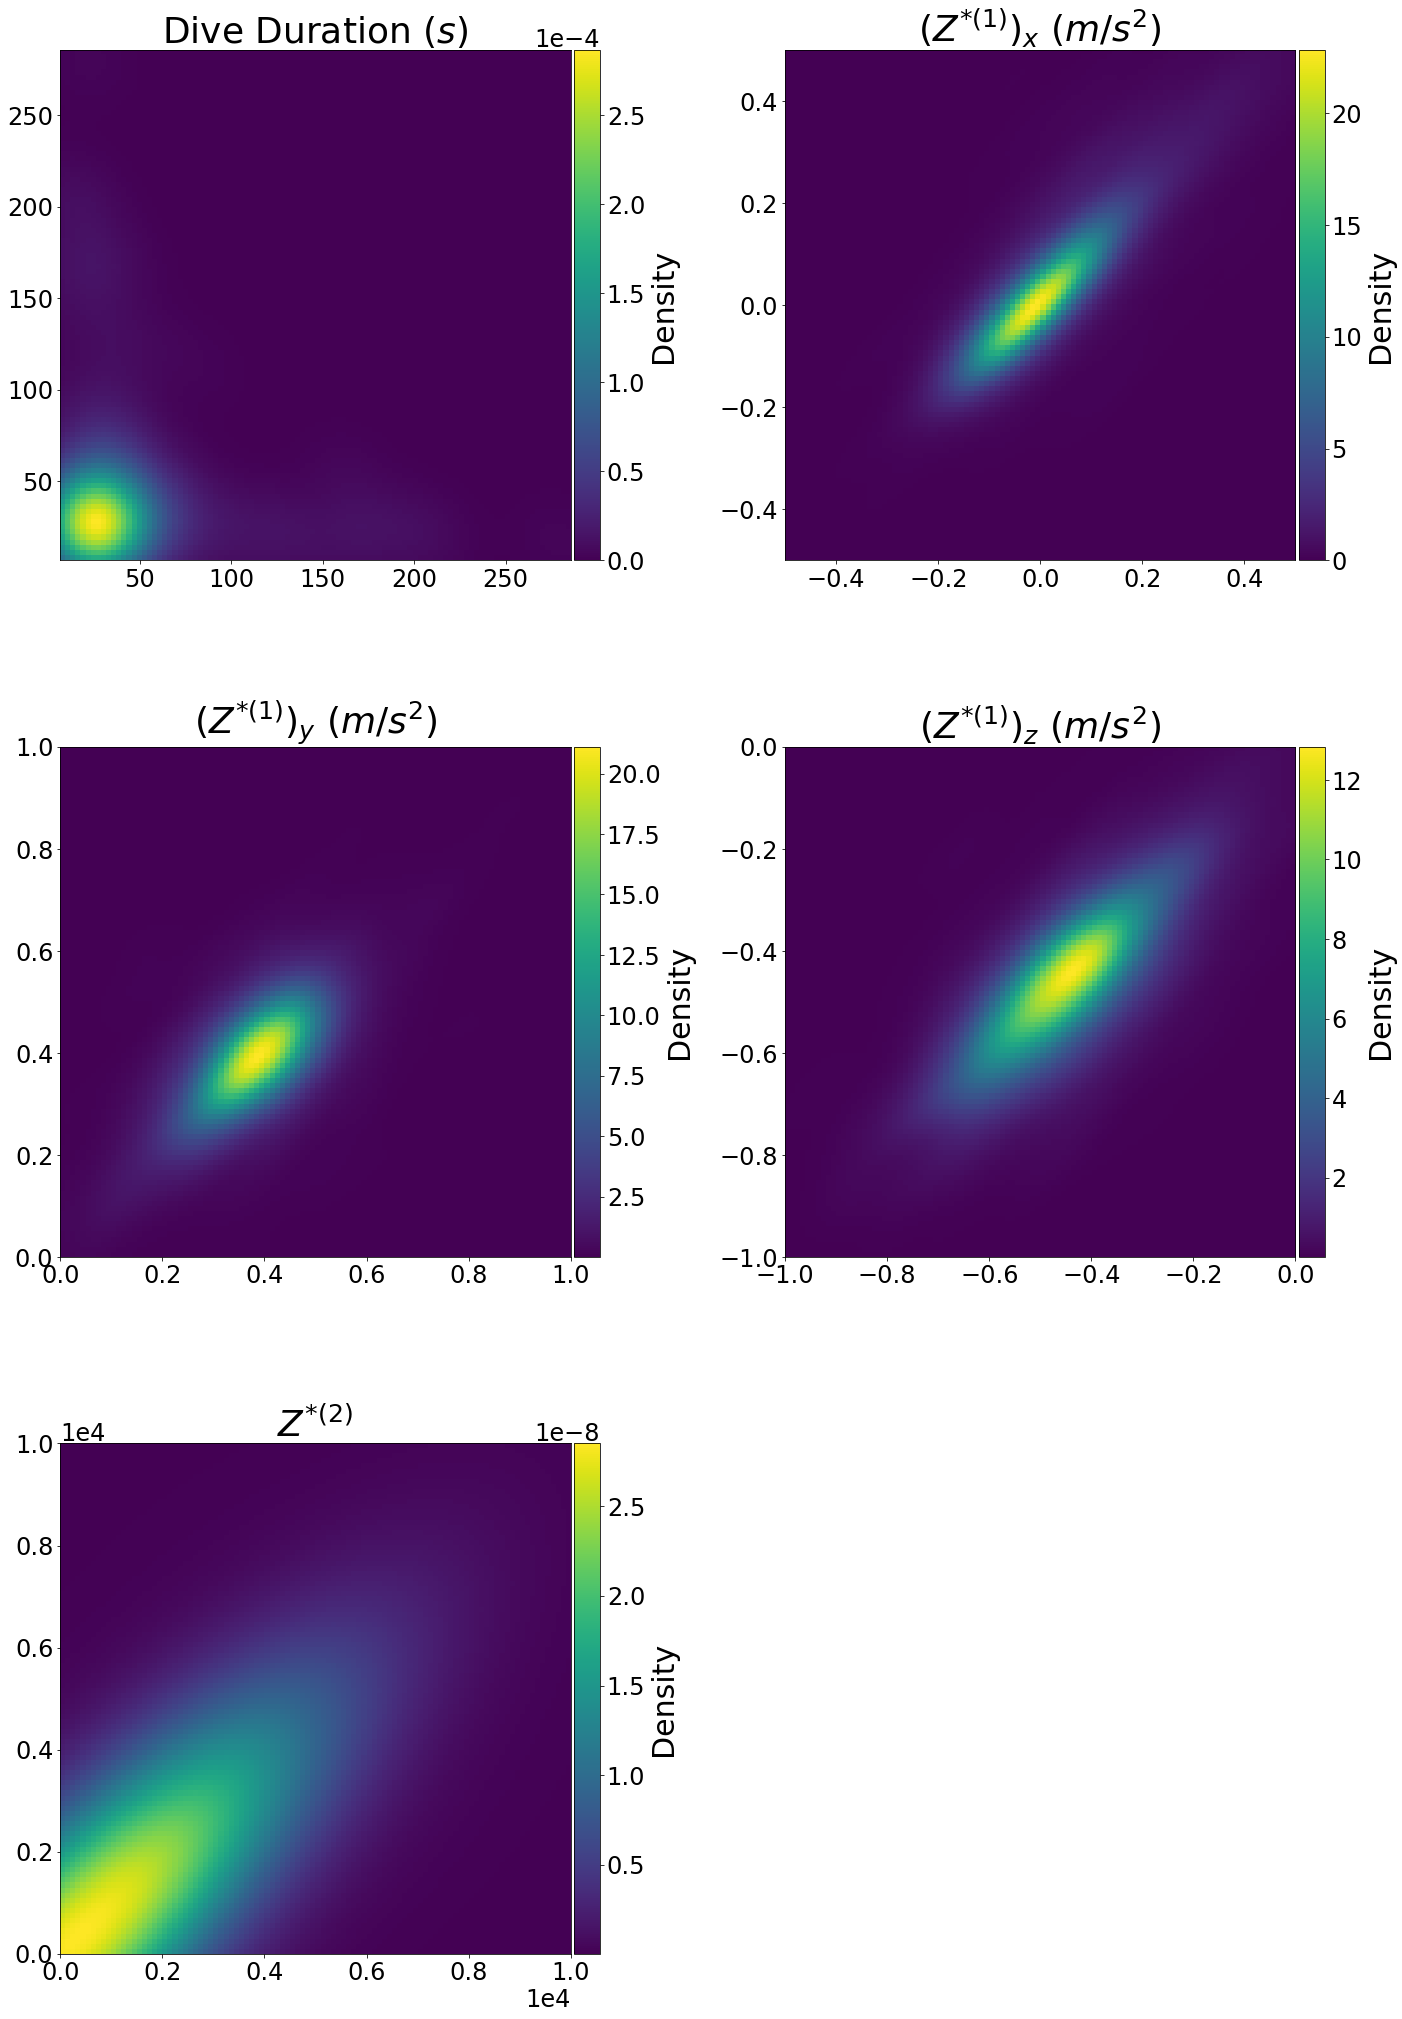

In [93]:
importlib.reload(Visualisor)
viz = Visualisor.Visualisor(pars,data,df)
viz.lagplot(lims={'peak_jerk':[0,50],
                  'roll_at_pj':[0,1],
                  'heading_var':[0,0.2],
                  'Ahat_low':[0,10000],
                  'FoVeDBA_high':[0,10],
                  'Vz':[-5,5],
                  'Ax':[-0.5,0.5],
                  'Ay':[0,1.0],
                  'Az':[-1.0,0.0]},
           file = '../Plots/lagplot.png')

# Train HHMM

In [15]:
deep_data = [data[i] for i in range(s_dive,e_dive)]
importlib.reload(HHMM)
hhmm = HHMM.HHMM(pars,deep_data)

# load model
hhmm = hhmm.load(HHMM_file)

stime = time.time()

if train_new:
    print('Training new model')
    hhmm.train_DM(deep_data,max_steps=5,max_iters=5)
    
    h = 0.01
    hhmm.get_SEs(deep_data,h)

    hhmm.save(HHMM_file)

print(hhmm.likelihood(deep_data))
print(time.time() - stime)
data,df = hhmm.label_df(data,df)

-19130.241372020042
4.2620580196380615


# Visualize Results

-19130.241372020042
Probability transistion matrix for dive types:
[[0.8488 0.1512]
 [0.9069 0.0931]]

Stationary distribution for dive types:
[[0.8571 0.1429]]




Probability transistion matrix for subdive behaviors, dive type 1:
[[0.7239 0.2761 0.    ]
 [0.0566 0.8873 0.0561]
 [0.     0.2467 0.7533]]

Stationary Distribution for subdive behaviors, dive type 1:
[[0.1431 0.6982 0.1587]]


Probability transistion matrix for subdive behaviors, dive type 2:
[[0.8709 0.1291 0.    ]
 [0.1348 0.829  0.0362]
 [0.     0.2458 0.7542]]

Stationary Distribution for subdive behaviors, dive type 2:
[[0.4764 0.4563 0.0673]]




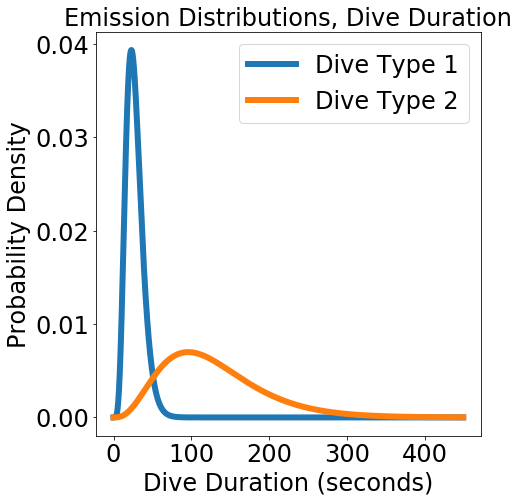

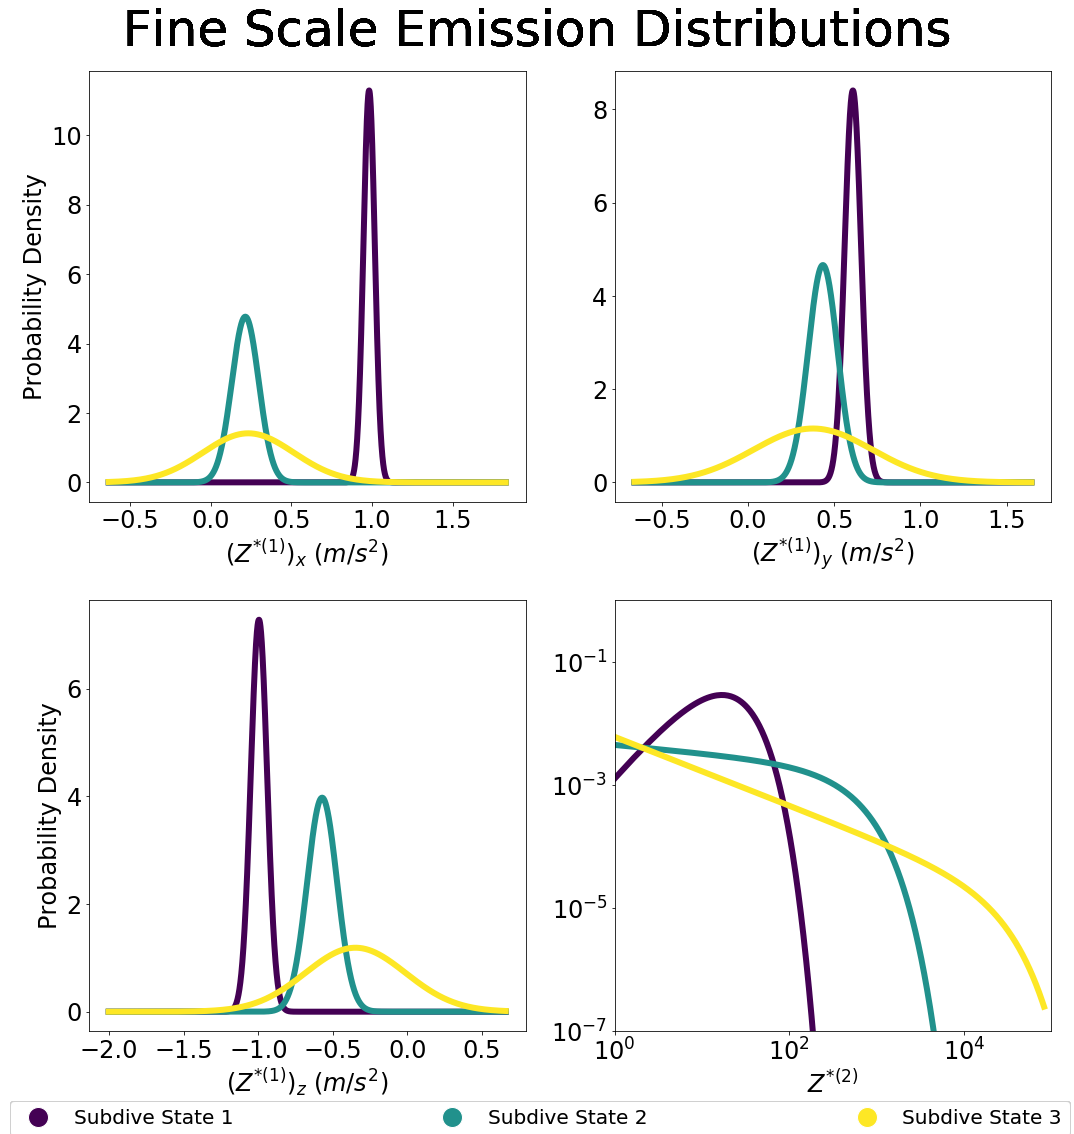

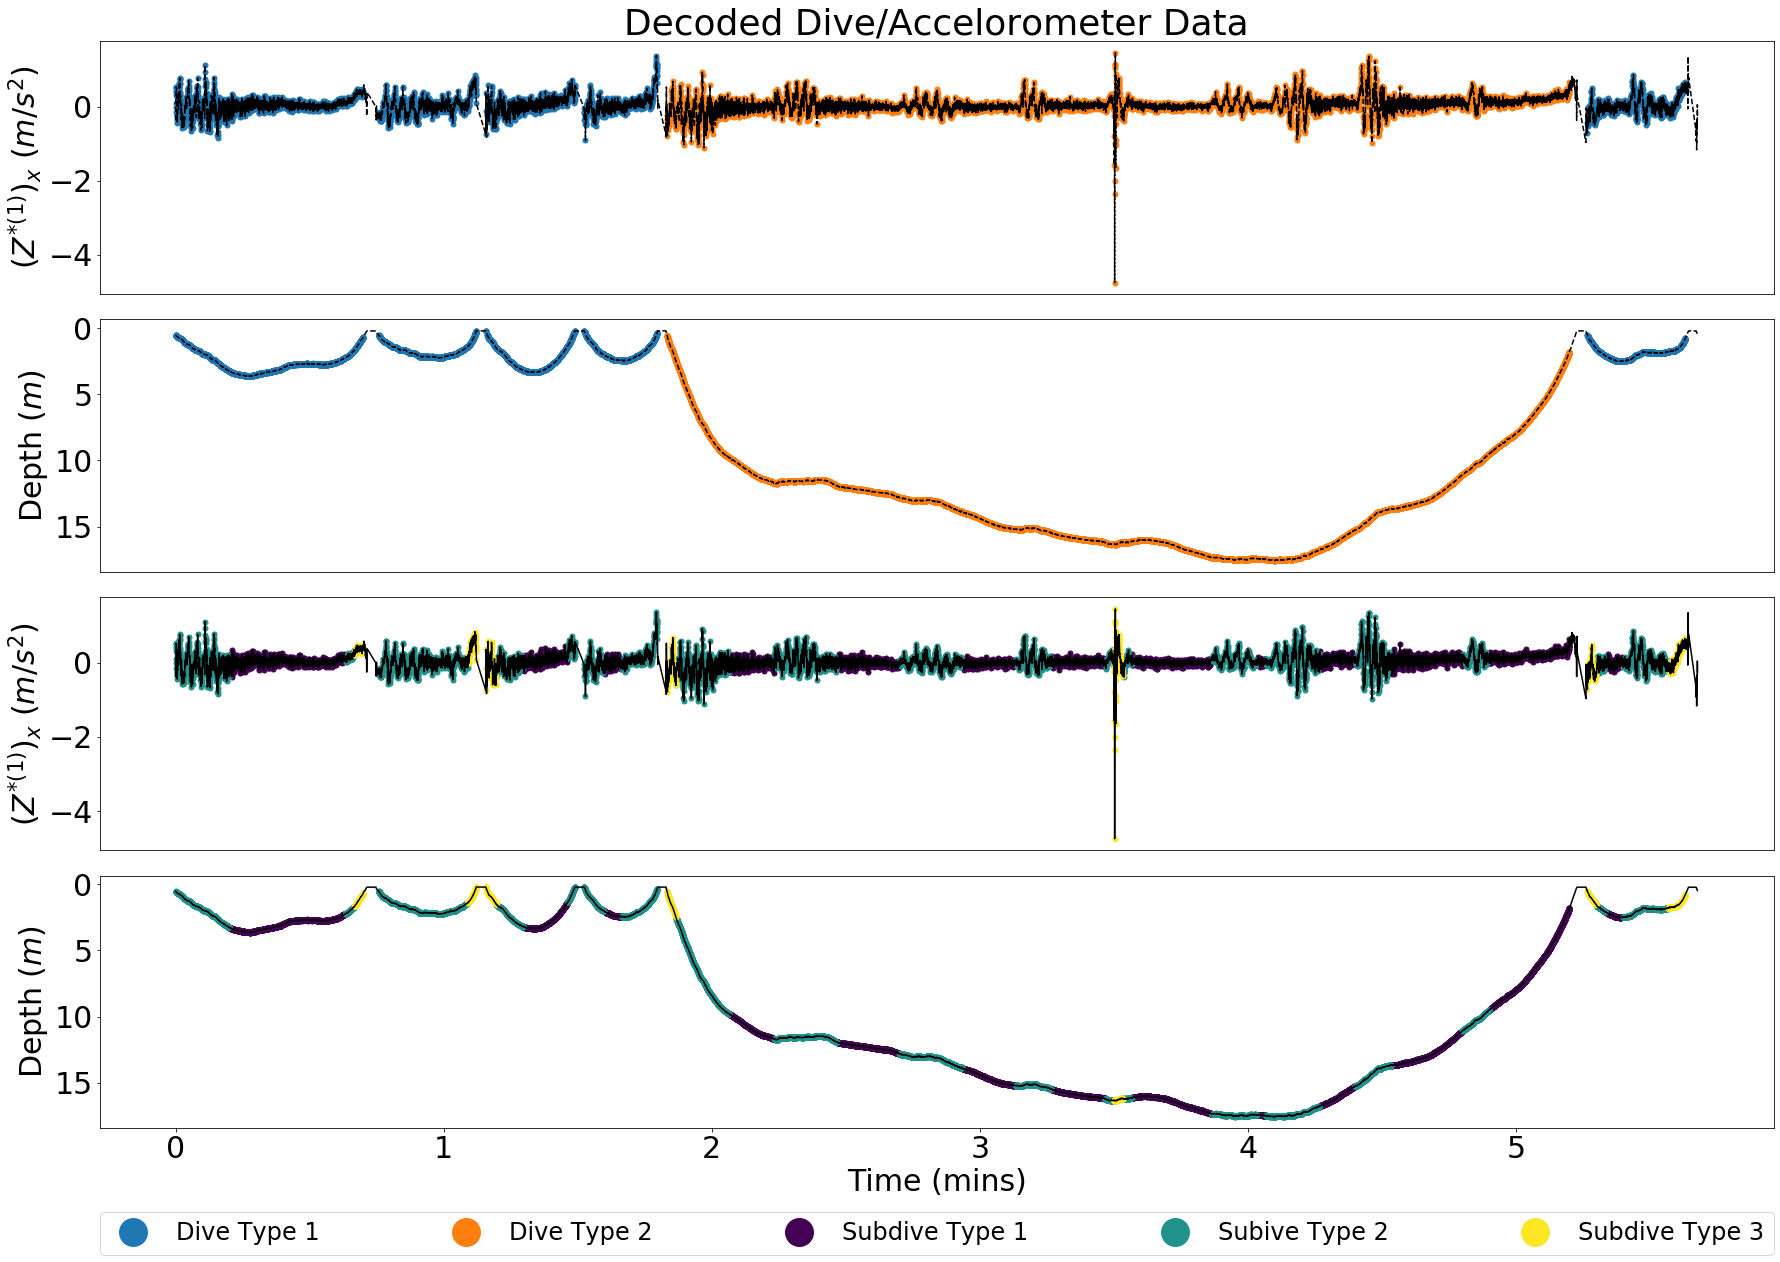

In [121]:
print(hhmm.likelihood(deep_data))

importlib.reload(Visualisor)
viz = Visualisor.Visualisor(pars,data,df)
viz.hhmm = hhmm
#rcParams.update({'figure.autolayout': True})
viz.plot_emission_probs(0,file='../Plots/coarse-emissions.png')
viz.plot_emission_probs(1,file='../Plots/fine-emissions.png')
viz.print_ptms()
viz.plot_dive_features(160,165,['Ax','depth'],[],
                       file = '../Plots/decoded_data.png')

# Histograms over emission distributions

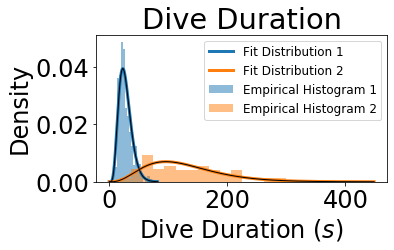

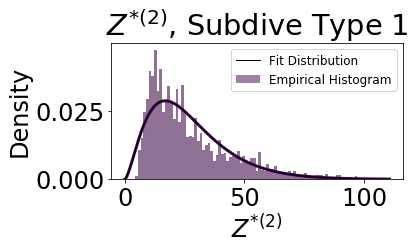

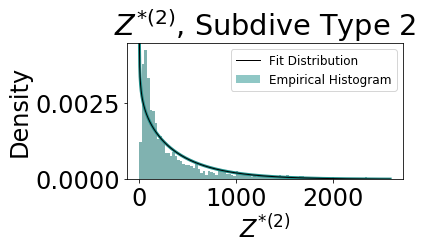

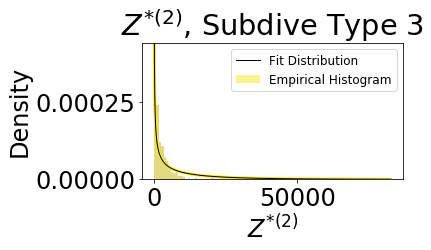

Ax


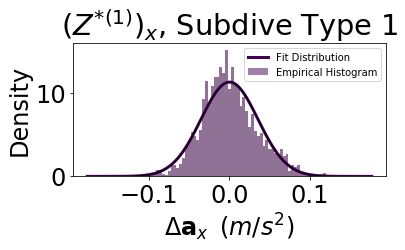

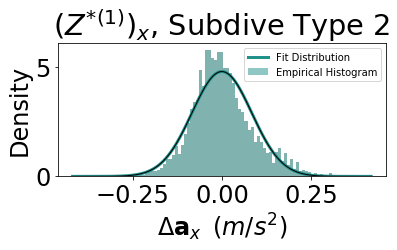

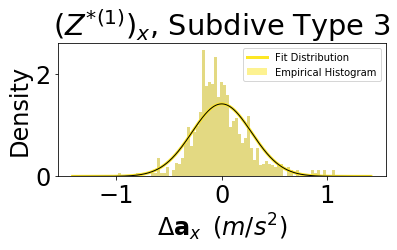

Ay


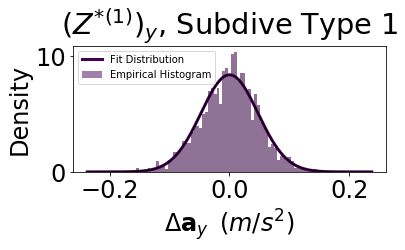

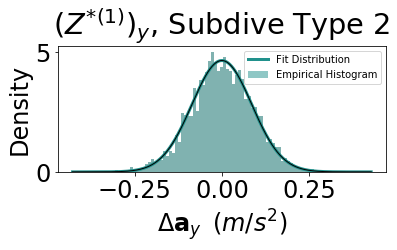

In [ ]:
# colors
dive_colors = [cm.get_cmap('tab10')(0),
               cm.get_cmap('tab10')(1)]
subdive_colors = [cm.get_cmap('viridis')(0),
                  cm.get_cmap('viridis')(0.5),
                  cm.get_cmap('viridis')(1.0)]

# dive duration
weights = [list([]),list([])]
values = []

for dive in data:
    weights[0].append(dive['dive_state_probs'][0])
    weights[1].append(dive['dive_state_probs'][1])
    values.append(dive['dive_duration'])
        
mu = hhmm.theta[0]['dive_duration']['mu']
sig = hhmm.theta[0]['dive_duration']['sig']
shape = np.square(mu)/np.square(sig)
scale = np.square(sig)/np.array(mu)
    
for state in range(hhmm.pars.K[0]):
    bins = np.linspace(0.01,mu[state]+5*sig[state],25)
    x = np.linspace(0.01,mu[state]+5*sig[state],10000)
    y = gamma.pdf(x,shape[state],0,scale[state])
    plt.hist(values,weights=weights[state],density=True,bins=bins,color=dive_colors[state],alpha=0.5)
    plt.plot(x,y,color=dive_colors[state],linewidth=3)
    
plt.legend(['Fit Distribution 1','Fit Distribution 2','Empirical Histogram 1','Empirical Histogram 2'],fontsize=12)
for state in range(hhmm.pars.K[0]):
    x = np.linspace(0.01,mu[state]+5*sig[state],10000)
    y = gamma.pdf(x,shape[state],0,scale[state])
    plt.plot(x,y,color='k',linewidth=1)
plt.title('Dive Duration')
plt.ylabel('Density')
plt.xlabel('Dive Duration $(s)$')
plt.tight_layout()
plt.savefig('../Plots/empirical_hist_dive_duration.png')
plt.show()
    
# A-hat
weights = [list([]),list([]),list([])]
values = []

for dive in data:
    for seg in dive['subdive_features']:
        weights[0].append(seg['subdive_state_probs'][0])
        weights[1].append(seg['subdive_state_probs'][1])
        weights[2].append(seg['subdive_state_probs'][2])
        values.append(seg['Ahat_low'])
        
mu = hhmm.theta[1][0]['Ahat_low']['mu']
sig = hhmm.theta[1][0]['Ahat_low']['sig']
shape = np.square(mu)/np.square(sig)
scale = np.square(sig)/np.array(mu)
for state in range(hhmm.pars.K[1]):
    bins = np.linspace(0.01,mu[state]+5*sig[state],100)
    plt.hist(values,weights=weights[state],density=True,bins=bins,color=subdive_colors[state],alpha=0.5)
    xlim = plt.gca().get_xlim()
    ylim = plt.gca().get_ylim()
    x = np.linspace(0.01,mu[state]+5*sig[state],10000)
    y = gamma.pdf(x,shape[state],0,scale[state])
    plt.plot(x,y,color='k',linewidth=1)
    plt.title(r'$Z^{*(2)}$, Subdive Type %d'%(state+1))
    plt.xlim(xlim)
    plt.xlabel(r'$Z^{*(2)}$')
    plt.ylim(ylim)
    plt.ylabel('Density')
    plt.legend(['Fit Distribution','Empirical Histogram'],fontsize=12)
    plt.hist(values,weights=weights[state],density=True,bins=bins,color='k',alpha=0.1)
    plt.plot(x,y,color=subdive_colors[state],linewidth=3)
    plt.plot(x,y,color='k',linewidth=1)
    plt.tight_layout()
    plt.savefig('../Plots/empirical_hist_ahat_%d.png'%state)
    plt.show()
    
    
# Ax
for feature in ['Ax','Ay','Az']:
    print(feature)
    weights = [list([]),list([]),list([])]
    values = [list([]),list([]),list([])]

    mu = hhmm.theta[1][0][feature]['mu']
    sig = hhmm.theta[1][0][feature]['sig']
    corr = expit(hhmm.theta[1][0][feature]['corr'])

    for state in range(hhmm.pars.K[1]):
        for dive in data:
            seg_tm1 = dive['subdive_features'][0]
            for seg in dive['subdive_features'][1:]:
                weights[state].append(seg['subdive_state_probs'][state])
                values[state].append(seg[feature] - (corr[state]*seg_tm1[feature] + (1.0-corr[state])*mu[state]))
                seg_tm1 = seg
                
    for state in range(hhmm.pars.K[1]):
        bins = np.linspace(-5*sig[state],5*sig[state],100)
        plt.hist(values[state],weights=weights[state],density=True,bins=bins,
                 color=subdive_colors[state],alpha=0.5)
        x = np.linspace(-5*sig[state],5*sig[state],10000)
        y = norm.pdf(x,0,sig[state])
        plt.plot(x,y,color=subdive_colors[state],linewidth=3)
        plt.ylabel('Density')
        plt.xlabel('$\Delta \mathbf{a}_%s \enspace (m/s^2)$'%feature[-1])
        plt.title(r'$\left(Z^{*(1)}\right)_%s$, Subdive Type %d'%(feature[-1],state+1))
        plt.legend(['Fit Distribution','Empirical Histogram'],fontsize=10)
        plt.plot(x,y,color='k',linewidth=1)
        plt.hist(values[state],weights=weights[state],density=True,bins=bins,
                 color='k',alpha=0.1)
        plt.tight_layout()
        plt.savefig('../Plots/empirical_hist_%s_%d.png'%(feature,state))
        plt.show()

# Psuedoresiduals

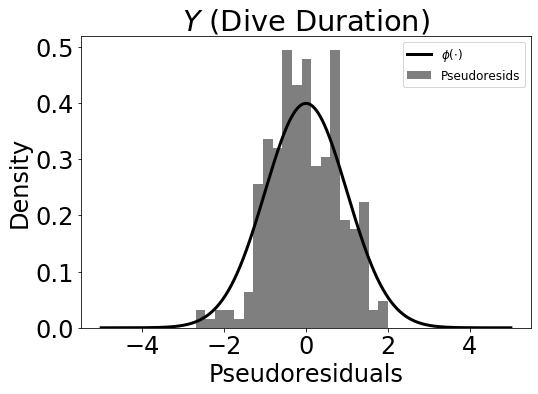

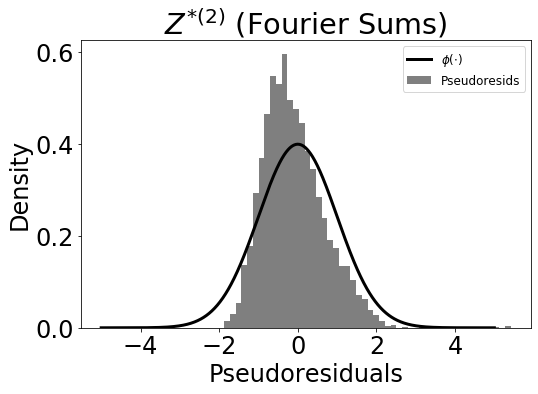

Ax


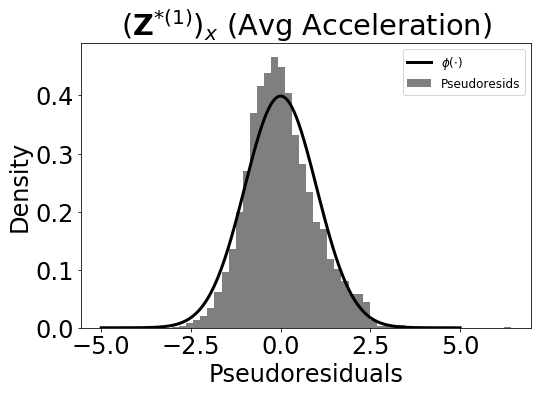

Ay


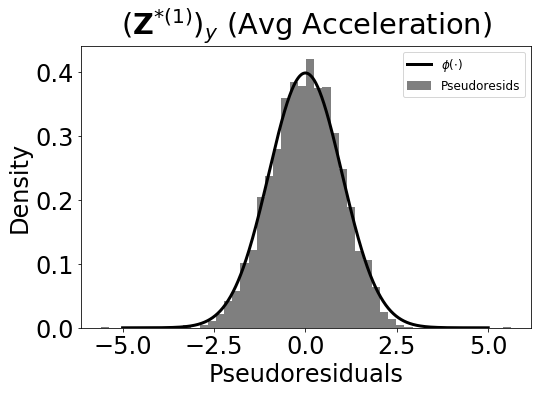

Az


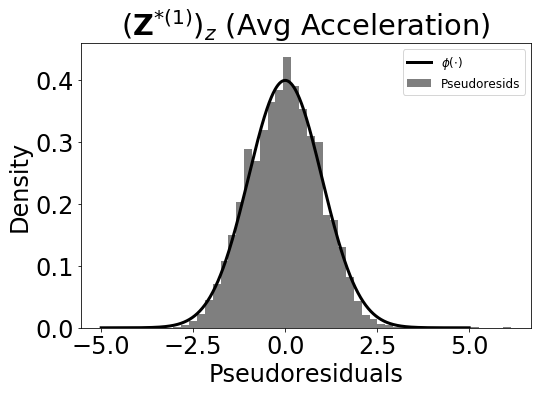

In [127]:
x = np.linspace(-5,5,1000)
y = norm.pdf(x)

# dive duration
mu = hhmm.theta[0]['dive_duration']['mu']
sig = hhmm.theta[0]['dive_duration']['sig']
shape = np.square(mu)/np.square(sig)
scale = np.square(sig)/np.array(mu)

psuedoresids = []

for dive in data:
    cdf = 0
    for state in range(hhmm.pars.K[0]):
        cdf += dive['dive_state_probs'][state] * \
               gamma.cdf(dive['dive_duration'],
                         shape[state],0,scale[state])
    psuedoresids.append(norm.ppf(cdf))

plt.figure(figsize=(8,6))
plt.hist(psuedoresids,density=True,bins=20,color='k',alpha=0.5)
plt.title('$Y$ (Dive Duration)')
plt.plot(x,y,color='k',linewidth=3)
plt.xlabel('Pseudoresiduals')
plt.ylabel('Density')
plt.legend(['$\phi(\cdot)$','Pseudoresids'],fontsize=12)
plt.tight_layout()
plt.savefig('../Plots/psedoresids_Dive_Duration.png')
plt.show()

# A-hat
mu = hhmm.theta[1][0]['Ahat_low']['mu']
sig = hhmm.theta[1][0]['Ahat_low']['sig']
shape = np.square(mu)/np.square(sig)
scale = np.square(sig)/np.array(mu)

psuedoresids = []

for dive in data:
    for seg in dive['subdive_features']:
        cdf = 0
        for state in range(hhmm.pars.K[1]):
            cdf += seg['subdive_state_probs'][state] * \
                    gamma.cdf(seg['Ahat_low'],shape[state],0,scale[state])
        psuedoresids.append(norm.ppf(cdf))
        
plt.figure(figsize=(8,6))     
plt.hist(psuedoresids,density=True,bins=50,color='k',alpha=0.5)
plt.title(r'$Z^{*(2)}$ (Fourier Sums)')
plt.plot(x,y,color='k',linewidth=3)
plt.xlabel('Pseudoresiduals')
plt.ylabel('Density')
plt.legend(['$\phi(\cdot)$','Pseudoresids'],fontsize=12)
plt.tight_layout()
plt.savefig('../Plots/psedoresids_ahat.png')
plt.show() 

for feature in ['Ax','Ay','Az']:
    print(feature)
    mu = hhmm.theta[1][0][feature]['mu']
    sig = hhmm.theta[1][0][feature]['sig']
    corr = expit(hhmm.theta[1][0][feature]['corr'])
    
    psuedoresids = []

    for state in range(hhmm.pars.K[1]):
        for dive in data:
            seg_tm1 = dive['subdive_features'][0]
            for seg in dive['subdive_features'][1:]:
                cdf = 0
                for state in range(hhmm.pars.K[1]):
                    mean = corr[state]*seg_tm1[feature] + (1.0-corr[state])*mu[state]
                    cdf += seg['subdive_state_probs'][state] * \
                            norm.cdf(seg[feature],mean,sig[state])
                seg_tm1 = seg
                psuedoresids.append(norm.ppf(cdf))
                
    plt.figure(figsize=(8,6))
    plt.hist(psuedoresids,density=True,bins=50,color='k',alpha=0.5)
    plt.plot(x,y,color='k',linewidth=3)
    plt.title(r'$\left(\mathbf{Z}^{*(1)}\right)_%s$ (Avg Acceleration)'%feature[-1])
    plt.xlabel('Pseudoresiduals')
    plt.ylabel('Density')
    plt.legend(['$\phi(\cdot)$','Pseudoresids'],fontsize=12)
    plt.tight_layout()
    plt.savefig('../Plots/psedoresids_%s.png'%feature)
    plt.show()   

# Make Tables

In [ ]:
table = r'''
\begin{table}[h!]
\centering
\label{table:emis_dists}
\caption{Estimates and standard errors of parameters for killer whale data.}
\begin{tabular}{ccccc}
\multirow{2}{*}{Feature}                 & \multirow{2}{*}{Dive / Subdive Type} & \multicolumn{3}{c}{Parameter Estimate}              \\
                                         &                                      & $\hat \mu$      & $\hat \sigma$   & $\hat \phi$     \\ \hline
\multirow{2}{*}{Dive Duration (seconds)} & 1                                    & $%.2f \pm %.2f$ & $%.2f \pm %.2f$ & ---             \\
                                         & 2                                    & $%.2f \pm %.2f$ & $%.2f \pm %.2f$ & ---             \\ \hline
\multirow{3}{*}{$Y^{*(1)}_x$}            & 1                                    & $%.2f \pm %.2f$ & $%.2f \pm %.2f$ & $%.2f \pm %.2f$ \\
                                         & 2                                    & $%.2f \pm %.2f$ & $%.2f \pm %.2f$ & $%.2f \pm %.2f$ \\
                                         & 3                                    & $%.2f \pm %.2f$ & $%.2f \pm %.2f$ & $%.2f \pm %.2f$ \\ \hline
\multirow{3}{*}{$Y^{*(1)}_y$}            & 1                                    & $%.2f \pm %.2f$ & $%.2f \pm %.2f$ & $%.2f \pm %.2f$ \\
                                         & 2                                    & $%.2f \pm %.2f$ & $%.2f \pm %.2f$ & $%.2f \pm %.2f$ \\
                                         & 3                                    & $%.2f \pm %.2f$ & $%.2f \pm %.2f$ & $%.2f \pm %.2f$ \\ \hline
\multirow{3}{*}{$Y^{*(1)}_z$}            & 1                                    & $%.2f \pm %.2f$ & $%.2f \pm %.2f$ & $%.2f \pm %.2f$ \\
                                         & 2                                    & $%.2f \pm %.2f$ & $%.2f \pm %.2f$ & $%.2f \pm %.2f$ \\
                                         & 3                                    & $%.2f \pm %.2f$ & $%.2f \pm %.2f$ & $%.2f \pm %.2f$ \\ \hline
\multirow{3}{*}{$Y^{*(2)}$}              & 1                                    & $%.2f \pm %.2f$ & $%.2f \pm %.2f$ & ---             \\
                                         & 2                                    & $%.2f \pm %.2f$ & $%.2f \pm %.2f$ & ---             \\
                                         & 3                                    & $%.2f \pm %.2f$ & $%.2f \pm %.2f$ & ---             \\ \hline
\end{tabular}
\end{table}
''' % (hhmm.theta[0]['dive_duration']['mu'][0],hhmm.SEs['dive_duration']['mu'][0],
       hhmm.theta[0]['dive_duration']['sig'][0],hhmm.SEs['dive_duration']['sig'][0],
       hhmm.theta[0]['dive_duration']['mu'][1],hhmm.SEs['dive_duration']['mu'][1],
       hhmm.theta[0]['dive_duration']['sig'][1],hhmm.SEs['dive_duration']['sig'][1],
       hhmm.theta[1][0]['Ax']['mu'][0],hhmm.SEs['Ax']['mu'][0],
       hhmm.theta[1][0]['Ax']['sig'][0],hhmm.SEs['Ax']['sig'][0],
       expit(hhmm.theta[1][0]['Ax']['corr'][0]),hhmm.SEs['Ax']['corr'][0],
       hhmm.theta[1][0]['Ax']['mu'][1],hhmm.SEs['Ax']['mu'][1],
       hhmm.theta[1][0]['Ax']['sig'][1],hhmm.SEs['Ax']['sig'][1],
       expit(hhmm.theta[1][0]['Ax']['corr'][1]),hhmm.SEs['Ax']['corr'][1],
       hhmm.theta[1][0]['Ax']['mu'][2],hhmm.SEs['Ax']['mu'][2],
       hhmm.theta[1][0]['Ax']['sig'][2],hhmm.SEs['Ax']['sig'][2],
       expit(hhmm.theta[1][0]['Ax']['corr'][2]),hhmm.SEs['Ax']['corr'][2],
       hhmm.theta[1][0]['Ay']['mu'][0],hhmm.SEs['Ay']['mu'][0],
       hhmm.theta[1][0]['Ay']['sig'][0],hhmm.SEs['Ay']['sig'][0],
       expit(hhmm.theta[1][0]['Ay']['corr'][0]),hhmm.SEs['Ay']['corr'][0],
       hhmm.theta[1][0]['Ay']['mu'][1],hhmm.SEs['Ay']['mu'][1],
       hhmm.theta[1][0]['Ay']['sig'][1],hhmm.SEs['Ay']['sig'][1],
       expit(hhmm.theta[1][0]['Ay']['corr'][1]),hhmm.SEs['Ay']['corr'][1],
       hhmm.theta[1][0]['Ay']['mu'][2],hhmm.SEs['Ay']['mu'][2],
       hhmm.theta[1][0]['Ay']['sig'][2],hhmm.SEs['Ay']['sig'][2],
       expit(hhmm.theta[1][0]['Ay']['corr'][2]),hhmm.SEs['Ay']['corr'][2],
       hhmm.theta[1][0]['Az']['mu'][0],hhmm.SEs['Az']['mu'][0],
       hhmm.theta[1][0]['Az']['sig'][0],hhmm.SEs['Az']['sig'][0],
       expit(hhmm.theta[1][0]['Az']['corr'][0]),hhmm.SEs['Az']['corr'][0],
       hhmm.theta[1][0]['Az']['mu'][1],hhmm.SEs['Az']['mu'][1],
       hhmm.theta[1][0]['Az']['sig'][1],hhmm.SEs['Az']['sig'][1],
       expit(hhmm.theta[1][0]['Az']['corr'][1]),hhmm.SEs['Az']['corr'][1],
       hhmm.theta[1][0]['Az']['mu'][2],hhmm.SEs['Az']['mu'][2],
       hhmm.theta[1][0]['Az']['sig'][2],hhmm.SEs['Az']['sig'][2],
       expit(hhmm.theta[1][0]['Az']['corr'][2]),hhmm.SEs['Az']['corr'][2],
       hhmm.theta[1][0]['Ahat_low']['mu'][0],hhmm.SEs['Ahat_low']['mu'][0],
       hhmm.theta[1][0]['Ahat_low']['sig'][0],hhmm.SEs['Ahat_low']['sig'][0],
       hhmm.theta[1][0]['Ahat_low']['mu'][1],hhmm.SEs['Ahat_low']['mu'][1],
       hhmm.theta[1][0]['Ahat_low']['sig'][1],hhmm.SEs['Ahat_low']['sig'][1],
       hhmm.theta[1][0]['Ahat_low']['mu'][2],hhmm.SEs['Ahat_low']['mu'][2],
       hhmm.theta[1][0]['Ahat_low']['sig'][2],hhmm.SEs['Ahat_low']['sig'][2])

print(table)

In [336]:
data

[{'dive_duration': 16.359999895095825,
  'subdive_features': [{'Ax': -0.09332699143256472,
    'Ay': 0.3881749769359222,
    'Az': -0.376278529526901,
    'Ahat_low': 1793.7481982758552,
    'start_time': Timestamp('2019-09-02 13:20:59.480000'),
    'end_time': Timestamp('2019-09-02 13:21:01.460000'),
    'subdive_state_probs': array([0.   , 0.075, 0.925])},
   {'Ax': -0.107372087278757,
    'Ay': 0.33285352756802616,
    'Az': -0.3208887187376586,
    'Ahat_low': 1022.4975076746606,
    'start_time': Timestamp('2019-09-02 13:21:01.480000'),
    'end_time': Timestamp('2019-09-02 13:21:03.460000'),
    'subdive_state_probs': array([0.    , 0.9798, 0.0202])},
   {'Ax': -0.058797987974183175,
    'Ay': 0.4961523544513654,
    'Az': -0.4528184059080506,
    'Ahat_low': 174.51201952887797,
    'start_time': Timestamp('2019-09-02 13:21:03.480000'),
    'end_time': Timestamp('2019-09-02 13:21:05.460000'),
    'subdive_state_probs': array([0.    , 0.9991, 0.0009])},
   {'Ax': -0.02345264635282

In [ ]:
table = r'''
\begin{table}[h!]
\centering
\label{table:emis_dists}
\caption{Estimates and standard errors of parameters for killer whale data.}
\begin{tabular}{ccccc}
\multirow{2}{*}{Feature}                 & \multirow{2}{*}{Dive / Subdive Type} & \multicolumn{3}{c}{Parameter Estimate}              \\
                                         &                                      & $\hat \mu$      & $\hat \sigma$   & $\hat \phi$     \\ \hline
\multirow{2}{*}{Dive Duration (seconds)} & 1                                    & $%.2f \pm %.2f$ & $%.2f \pm %.2f$ & ---             \\
                                         & 2                                    & $%.2f \pm %.2f$ & $%.2f \pm %.2f$ & ---             \\ \hline
\multirow{3}{*}{$Y^{*(1)}_x$}            & 1                                    & $%.2f \pm %.2f$ & $%.2f \pm %.2f$ & $%.2f \pm %.2f$ \\
                                         & 2                                    & $%.2f \pm %.2f$ & $%.2f \pm %.2f$ & $%.2f \pm %.2f$ \\
                                         & 3                                    & $%.2f \pm %.2f$ & $%.2f \pm %.2f$ & $%.2f \pm %.2f$ \\ \hline
\multirow{3}{*}{$Y^{*(1)}_y$}            & 1                                    & $%.2f \pm %.2f$ & $%.2f \pm %.2f$ & $%.2f \pm %.2f$ \\
                                         & 2                                    & $%.2f \pm %.2f$ & $%.2f \pm %.2f$ & $%.2f \pm %.2f$ \\
                                         & 3                                    & $%.2f \pm %.2f$ & $%.2f \pm %.2f$ & $%.2f \pm %.2f$ \\ \hline
\multirow{3}{*}{$Y^{*(1)}_z$}            & 1                                    & $%.2f \pm %.2f$ & $%.2f \pm %.2f$ & $%.2f \pm %.2f$ \\
                                         & 2                                    & $%.2f \pm %.2f$ & $%.2f \pm %.2f$ & $%.2f \pm %.2f$ \\
                                         & 3                                    & $%.2f \pm %.2f$ & $%.2f \pm %.2f$ & $%.2f \pm %.2f$ \\ \hline
\multirow{3}{*}{$Y^{*(2)}$}              & 1                                    & $%.2f \pm %.2f$ & $%.2f \pm %.2f$ & ---             \\
                                         & 2                                    & $%.2f \pm %.2f$ & $%.2f \pm %.2f$ & ---             \\
                                         & 3                                    & $%.2f \pm %.2f$ & $%.2f \pm %.2f$ & ---             \\ \hline
\end{tabular}
\end{table}
''' % (hhmm.theta[0]['dive_duration']['mu'][0],hhmm.SEs['dive_duration']['mu'][0],
       hhmm.theta[0]['dive_duration']['sig'][0],hhmm.SEs['dive_duration']['sig'][0],
       hhmm.theta[0]['dive_duration']['mu'][1],hhmm.SEs['dive_duration']['mu'][1],
       hhmm.theta[0]['dive_duration']['sig'][1],hhmm.SEs['dive_duration']['sig'][1],
       hhmm.theta[1][0]['Ax']['mu'][0],hhmm.SEs['Ax']['mu'][0],
       hhmm.theta[1][0]['Ax']['sig'][0],hhmm.SEs['Ax']['sig'][0],
       expit(hhmm.theta[1][0]['Ax']['corr'][0]),hhmm.SEs['Ax']['corr'][0],
       hhmm.theta[1][0]['Ax']['mu'][1],hhmm.SEs['Ax']['mu'][1],
       hhmm.theta[1][0]['Ax']['sig'][1],hhmm.SEs['Ax']['sig'][1],
       expit(hhmm.theta[1][0]['Ax']['corr'][1]),hhmm.SEs['Ax']['corr'][1],
       hhmm.theta[1][0]['Ax']['mu'][2],hhmm.SEs['Ax']['mu'][2],
       hhmm.theta[1][0]['Ax']['sig'][2],hhmm.SEs['Ax']['sig'][2],
       expit(hhmm.theta[1][0]['Ax']['corr'][2]),hhmm.SEs['Ax']['corr'][2],
       hhmm.theta[1][0]['Ay']['mu'][0],hhmm.SEs['Ay']['mu'][0],
       hhmm.theta[1][0]['Ay']['sig'][0],hhmm.SEs['Ay']['sig'][0],
       expit(hhmm.theta[1][0]['Ay']['corr'][0]),hhmm.SEs['Ay']['corr'][0],
       hhmm.theta[1][0]['Ay']['mu'][1],hhmm.SEs['Ay']['mu'][1],
       hhmm.theta[1][0]['Ay']['sig'][1],hhmm.SEs['Ay']['sig'][1],
       expit(hhmm.theta[1][0]['Ay']['corr'][1]),hhmm.SEs['Ay']['corr'][1],
       hhmm.theta[1][0]['Ay']['mu'][2],hhmm.SEs['Ay']['mu'][2],
       hhmm.theta[1][0]['Ay']['sig'][2],hhmm.SEs['Ay']['sig'][2],
       expit(hhmm.theta[1][0]['Ay']['corr'][2]),hhmm.SEs['Ay']['corr'][2],
       hhmm.theta[1][0]['Az']['mu'][0],hhmm.SEs['Az']['mu'][0],
       hhmm.theta[1][0]['Az']['sig'][0],hhmm.SEs['Az']['sig'][0],
       expit(hhmm.theta[1][0]['Az']['corr'][0]),hhmm.SEs['Az']['corr'][0],
       hhmm.theta[1][0]['Az']['mu'][1],hhmm.SEs['Az']['mu'][1],
       hhmm.theta[1][0]['Az']['sig'][1],hhmm.SEs['Az']['sig'][1],
       expit(hhmm.theta[1][0]['Az']['corr'][1]),hhmm.SEs['Az']['corr'][1],
       hhmm.theta[1][0]['Az']['mu'][2],hhmm.SEs['Az']['mu'][2],
       hhmm.theta[1][0]['Az']['sig'][2],hhmm.SEs['Az']['sig'][2],
       expit(hhmm.theta[1][0]['Az']['corr'][2]),hhmm.SEs['Az']['corr'][2],
       hhmm.theta[1][0]['Ahat_low']['mu'][0],hhmm.SEs['Ahat_low']['mu'][0],
       hhmm.theta[1][0]['Ahat_low']['sig'][0],hhmm.SEs['Ahat_low']['sig'][0],
       hhmm.theta[1][0]['Ahat_low']['mu'][1],hhmm.SEs['Ahat_low']['mu'][1],
       hhmm.theta[1][0]['Ahat_low']['sig'][1],hhmm.SEs['Ahat_low']['sig'][1],
       hhmm.theta[1][0]['Ahat_low']['mu'][2],hhmm.SEs['Ahat_low']['mu'][2],
       hhmm.theta[1][0]['Ahat_low']['sig'][2],hhmm.SEs['Ahat_low']['sig'][2])

print(table)

In [ ]:
ptm = HHMM.eta_2_ptm(hhmm.eta[0])
delta = np.array([0.5,0.5])
for _ in range(100):
    delta = delta.dot(ptm)

gamma0 = r'''$$\hat \Gamma = \begin{pmatrix} 
%.3f & %.3f \\
%.3f & %.3f
\end{pmatrix}$$
$$\hat \delta = \begin{pmatrix} %.3f & %.3f \end{pmatrix}$$
'''% tuple(np.concatenate([ptm.flatten(),delta]))

print(gamma0)

In [ ]:
ptm1 = HHMM.eta_2_ptm(hhmm.eta[1][0])
delta1 = np.array([0.3333,0.3333,0.3334])
for _ in range(100):
    delta1 = delta1.dot(ptm1)
    
ptm2 = HHMM.eta_2_ptm(hhmm.eta[1][1])
delta2 = np.array([0.3333,0.3333,0.3334])
for _ in range(100):
    delta2 = delta2.dot(ptm2)

gamma0 = r'''$$\hat \Gamma^{*(1)} = \begin{pmatrix} 
%.3f & %.3f & %.3f \\
%.3f & %.3f & %.3f \\
%.3f & %.3f & %.3f
\end{pmatrix}$$
$$\hat \delta^{*(1)} = \begin{pmatrix} %.3f & %.3f & %.3f \end{pmatrix}$$

$$\hat \Gamma^{*(2)} = \begin{pmatrix} 
%.3f & %.3f & %.3f \\
%.3f & %.3f & %.3f \\
%.3f & %.3f & %.3f
\end{pmatrix}$$
$$\hat \delta^{*(2)} = \begin{pmatrix} %.3f & %.3f & %.3f \end{pmatrix}$$
''' % tuple(np.concatenate([ptm1.flatten(),delta1,ptm2.flatten(),delta2]))

print(gamma0)